## Quantized Model Benchmarking

Quantized Models sourced from https://github.com/akbartus/DepthAnything-on-Browser?tab=readme-ov-file

In [4]:
#!pip install onnx onnxruntime
#!apt-get install -y libopenblas-dev libomp-dev
#!pip install onnxruntime-gpu

In [4]:
import os
import time
import numpy as np
import onnxruntime as ort
from PIL import Image

# --------------------------
# Helpers
# --------------------------
def load_rgb_image(path, target_size=None):
    img = Image.open(path).convert("RGB")
    arr_orig = np.array(img).astype(np.float32)      # original H0,W0,3
    if target_size is not None:
        img = img.resize(target_size, Image.BILINEAR)
    arr = np.array(img).astype(np.float32) / 255.0   # Normalize for inference
    x = np.transpose(arr, (2,0,1))[np.newaxis, ...]  # [1,3,H,W]
    return arr_orig, x


def load_gt_image(path):
    img = Image.open(path).convert("L")
    return np.array(img).astype(np.float32)  # 0-255

def postprocess_pred(pred):
    pred_array = np.array(pred[0])  # take first output, make sure right dimensions
    if pred_array.ndim == 4:  # (1,1,H,W)
        pred_array = pred_array[0,0]
    elif pred_array.ndim == 3 and pred_array.shape[0] == 1:  # (1,H,W)
        pred_array = pred_array[0]
    pred_array = 1.0 - pred_array       # flip
    pred_array = (pred_array * 255.0).clip(0,255) # scale and clip to 0-255
    return pred_array.astype(np.float32)

# --------------------------
# Paths & models
# --------------------------
folder = "Snapshots"
DAv2_small = "./quantized_models/depthanythingv2-vits.onnx"
DAv2_small_dynamic = "./quantized_models/depthanythingv2-vits-dynamic.onnx"
DAv2_small_dynamic_quant = "./quantized_models/depthanythingv2-vits-dynamic-quant.onnx"
DAv2_small_quant = "./quantized_models/depthanythingv2-vits-quant.onnx"

# --------------------------
# Prepare file pairs
# --------------------------
rgb_files = sorted([f for f in os.listdir(folder) if f.startswith("rbg_")])
gt_files  = sorted([f for f in os.listdir(folder) if f.startswith("gt_")])
pairs = list(zip(rgb_files, gt_files))
print(f"Found {len(pairs)} image pairs")


Found 100 image pairs


## Benchmarking on CPU

In [6]:
# for CPU runtime
sess_small = ort.InferenceSession(DAv2_small, providers=["CPUExecutionProvider"])
sess_dynamic = ort.InferenceSession(DAv2_small_dynamic, providers=["CPUExecutionProvider"])
sess_dynamic_quant = ort.InferenceSession(DAv2_small_dynamic_quant, providers=["CPUExecutionProvider"])
sess_small_quant = ort.InferenceSession(DAv2_small_quant, providers=["CPUExecutionProvider"])
sessions = {
    "FP32 Small": sess_small,
    "FP32 Dynamic": sess_dynamic,
    "INT8 Dynamic": sess_dynamic_quant,
    "INT8 Small": sess_small_quant
}

# --------------------------
# Model input size requirements
# --------------------------
model_input_shapes = {
    "FP32 Small": (518,518),         # fixed-size FP32 model
    "FP32 Dynamic": None,            # dynamic input
    "INT8 Dynamic": None,
    "INT8 Small": (518,518)
}

# --------------------------
# Evaluation storage (image-first)
# --------------------------
results = {}  # now results[image_file][model_name] = {...}

for name, sess in sessions.items():
    input_name = sess.get_inputs()[0].name
    target_size = model_input_shapes[name]

    for rgb_file, gt_file in pairs:
        # Initialize per-image dict if not exists
        if rgb_file not in results:
            results[rgb_file] = {}

        # Load input and GT
        img_orig, x = load_rgb_image(os.path.join(folder, rgb_file), target_size)
        gt = load_gt_image(os.path.join(folder, gt_file))

        # Inference
        t0 = time.time()
        pred = sess.run(None, {input_name: x})
        t1 = time.time()
        inf_time = t1 - t0

        # Postprocess
        pred_proc = postprocess_pred(pred)

        # Resize prediction to GT if needed
        if pred_proc.shape != gt.shape:
            pred_proc = np.array(Image.fromarray(pred_proc).resize((gt.shape[1], gt.shape[0]), Image.BILINEAR))

        # Compute per-image MSE
        mse = np.mean((pred_proc - gt)**2)

        # Store results indexed by image first
        results[rgb_file][name] = {
            "orig_rgb": img_orig.copy(), # Full resolution original RGB, [H, W]
            "input_rgb": x.copy(),       # Resized RGB [518 x 518]
            "pred": pred_proc.copy(),    # [H,W]
            "gt": gt.copy(),             # [H,W]
            "mse": mse,
            "inference_time": inf_time
        }

# --------------------------
# Print average metrics per model
# --------------------------
for model_name in sessions.keys():
    all_mse = [results[img][model_name]["mse"] for img in results]
    all_time = [results[img][model_name]["inference_time"] for img in results]
    print(f"{model_name}: Avg MSE={np.mean(all_mse):.2f}, Avg inference time={np.mean(all_time):.4f}s")

print("\n--- Done ---")

FP32 Small: Avg MSE=4468.89, Avg inference time=1.5397s
FP32 Dynamic: Avg MSE=4771.67, Avg inference time=0.1827s
INT8 Dynamic: Avg MSE=5160.70, Avg inference time=0.2124s
INT8 Small: Avg MSE=4471.48, Avg inference time=1.5785s

--- Done ---


## Benchmarking on GPU

In [7]:
# --------------------------
# GPU providers (T4)
# --------------------------
providers = [
    "CUDAExecutionProvider",
    "CPUExecutionProvider"
]

# --------------------------
# GPU sessions
# --------------------------
sess_small = ort.InferenceSession(DAv2_small, providers=providers)
sess_dynamic = ort.InferenceSession(DAv2_small_dynamic, providers=providers)
sess_dynamic_quant = ort.InferenceSession(DAv2_small_dynamic_quant, providers=providers)
sess_small_quant = ort.InferenceSession(DAv2_small_quant, providers=providers)

sessions = {
    "FP32 Small": sess_small,
    "FP32 Dynamic": sess_dynamic,
    "INT8 Dynamic": sess_dynamic_quant,
    "INT8 Small": sess_small_quant
}

# --------------------------
# Model input size requirements
# --------------------------
model_input_shapes = {
    "FP32 Small": (518,518),         # fixed-size FP32 model
    "FP32 Dynamic": None,            # dynamic input
    "INT8 Dynamic": None,
    "INT8 Small": (518,518)
}

# --------------------------
# GPU warmup
# --------------------------
print("Warming up GPU…")
dummy = np.random.rand(1,3,518,518).astype(np.float32)
for name, sess in sessions.items():
    input_name = sess.get_inputs()[0].name
    for _ in range(5):
        _ = sess.run(None, {input_name: dummy})

# --------------------------
# Evaluation storage (image-first)
# --------------------------
results = {}

for name, sess in sessions.items():
    input_name = sess.get_inputs()[0].name
    target_size = model_input_shapes[name]

    for rgb_file, gt_file in pairs:
        # Initialize per-image dict if not exists
        if rgb_file not in results:
            results[rgb_file] = {}

        # Load input and GT
        img_orig, x = load_rgb_image(os.path.join(folder, rgb_file), target_size)
        gt = load_gt_image(os.path.join(folder, gt_file))

        # Inference
        t0 = time.time()
        pred = sess.run(None, {input_name: x})
        t1 = time.time()
        inf_time = t1 - t0

        # Postprocess
        pred_proc = postprocess_pred(pred)

        # Resize prediction to GT if needed
        if pred_proc.shape != gt.shape:
            pred_proc = np.array(Image.fromarray(pred_proc).resize((gt.shape[1], gt.shape[0]), Image.BILINEAR))

        # Compute per-image MSE
        mse = np.mean((pred_proc - gt)**2)

        # Store results indexed by image first
        results[rgb_file][name] = {
            "orig_rgb": img_orig.copy(), # Full resolution original RGB, [H, W]
            "input_rgb": x.copy(),       # Resized RGB [518 x 518]
            "pred": pred_proc.copy(),    # [H,W]
            "gt": gt.copy(),             # [H,W]
            "mse": mse,
            "inference_time": inf_time
        }
# --------------------------
# Print average metrics per model
# --------------------------
for model_name in sessions.keys():
    all_mse = [results[img][model_name]["mse"] for img in results]
    all_time = [results[img][model_name]["inference_time"] for img in results]
    print(f"{model_name}: Avg MSE={np.mean(all_mse):.2f}, Avg inference time={np.mean(all_time):.4f}s")

print("\n--- Done ---")


Warming up GPU…
FP32 Small: Avg MSE=4468.89, Avg inference time=0.0431s
FP32 Dynamic: Avg MSE=4771.67, Avg inference time=0.0091s
INT8 Dynamic: Avg MSE=5118.27, Avg inference time=0.1535s
INT8 Small: Avg MSE=4471.47, Avg inference time=0.0442s

--- Done ---


## Write Outputs to directory (optional)

In [8]:
os.makedirs("outputs", exist_ok=True)

for rgb_file in results:
    for model_name, data in results[rgb_file].items():
        pred_proc = data["pred"]  # already post-processed [H,W] float32 0-255

        # save output as uint8
        out_img = Image.fromarray(pred_proc.astype(np.uint8))

        safe_name = model_name.replace(" ", "_")
        out_path = os.path.join("outputs",
                                f"{os.path.splitext(rgb_file)[0]}_{safe_name}.png")
        out_img.save(out_path)

print(f"saved {len(results)} images x {len(sessions)} models → outputs/")

saved 100 images x 4 models → outputs/


## Display Outputs for Comparison with Ground Truth

In [63]:
figures_dir = os.path.join(os.getcwd(), "figures")
os.makedirs(figures_dir, exist_ok=True)

Saved figure to /content/figures/quant_model_comparison.png


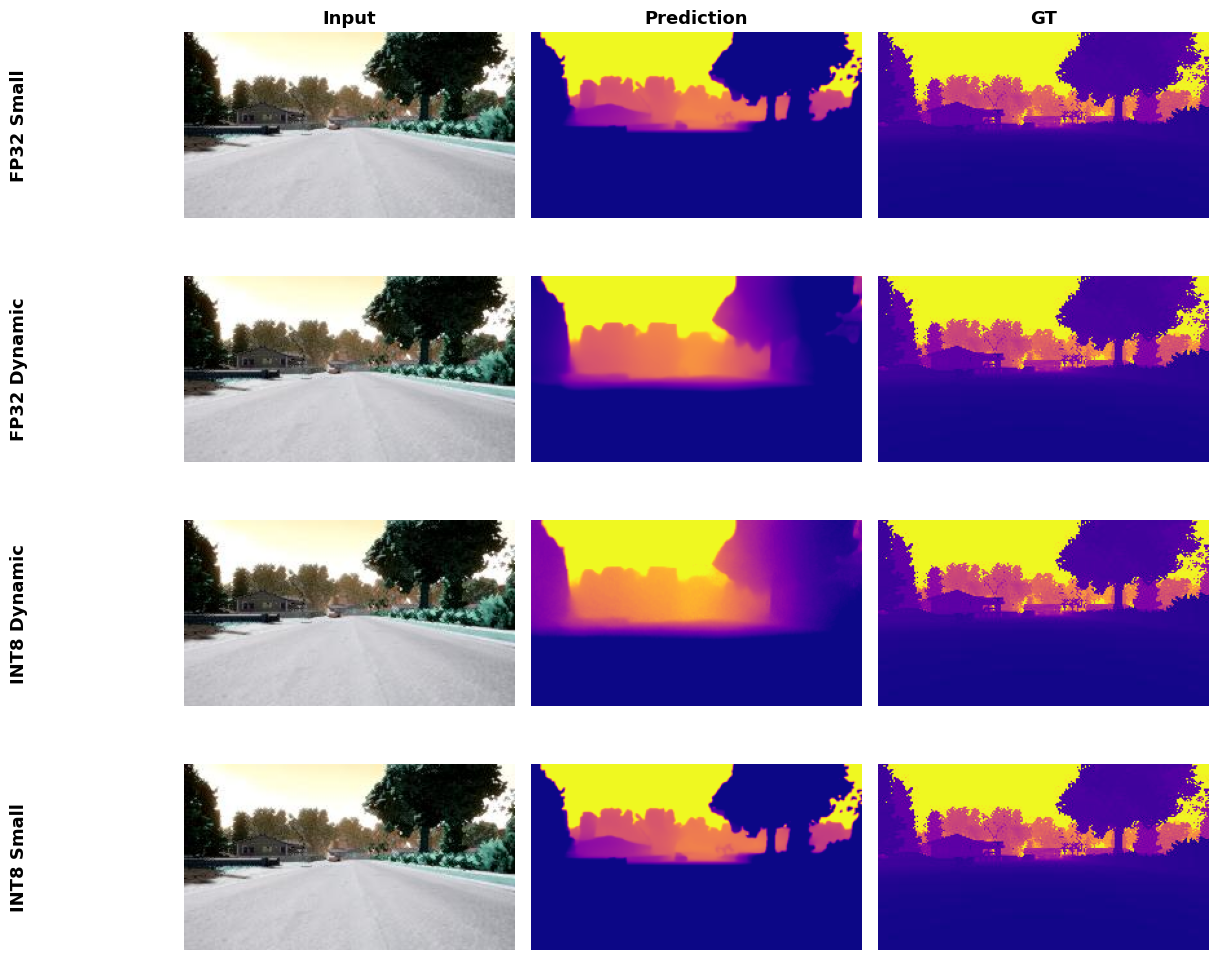

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Choose the image
img_file = "rbg_1761185311.0163574_0.jpg"
image_results = results[img_file]

models = ["FP32 Small", "FP32 Dynamic", "INT8 Dynamic", "INT8 Small"]
cols = ["Input", "Prediction", "GT"]

plt.figure(figsize=(12, 10))  # Adjust for 4 rows

for row_idx, model_name in enumerate(models):
    data = image_results[model_name]
    for col_idx, col_name in enumerate(cols):
        plt_idx = row_idx * len(cols) + col_idx + 1
        plt.subplot(len(models), len(cols), plt_idx)

        if col_name == "Input":
            img = data["orig_rgb"].astype(np.uint8)  # full-resolution original RGB
            plt.imshow(img)
        elif col_name == "Prediction":
            plt.imshow(data["pred"], cmap="plasma")
        else:  # GT
            plt.imshow(data["gt"], cmap="plasma")

        # Top titles for first row
        if row_idx == 0:
            plt.title(col_name, fontsize=13, fontweight="bold")

        # Hide axis ticks
        plt.axis("off")

    # Add a big model name label centered across the row
    plt.text(
        x=-0.5, y=0.5,
        s=model_name,
        fontsize=13, fontweight="bold", rotation=90,
        ha="center", va="center",
        transform=plt.subplot(len(models), len(cols), row_idx * len(cols) + 1).transAxes
    )

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)

save_path = os.path.join(figures_dir, f"quant_model_comparison.png")
plt.savefig(save_path, bbox_inches='tight', dpi=150)
print(f"Saved figure to {save_path}")

plt.show()


## Statically Quantize Small Model (depthanythingv2-vits-quant.onnx)

In [40]:
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType, QuantFormat
import onnx
import numpy as np
from PIL import Image
import os

# --------------------------
# Paths
# --------------------------
fp32_model = "./quantized_models/depthanythingv2-vits.onnx"
int8_model_static = "./quantized_models/depthanythingv2-vits-quant.onnx"
calib_folder = "Snapshots"

# --------------------------
# Calibration Data Reader
# --------------------------
class DepthCalibDataReader(CalibrationDataReader):
    def __init__(self, image_folder, input_name, target_size=(518,518), max_samples=50):
        self.input_name = input_name
        # Only take RGB images
        self.files = [f for f in os.listdir(image_folder) if f.startswith("rbg_")]
        self.files = self.files[:max_samples]
        self.image_folder = image_folder
        self.target_size = target_size
        self.index = 0  # current index in files

        if len(self.files) == 0:
            raise ValueError(f"No calibration images found in {image_folder}")

    def preprocess(self, path):
        img = Image.open(path).convert("RGB")
        if self.target_size is not None:
            img = img.resize(self.target_size, Image.BILINEAR)
        arr = np.array(img).astype(np.float32) / 255.0  # normalize 0-1
        return np.transpose(arr, (2,0,1))[np.newaxis, ...]  # [1,3,H,W]

    def get_next(self):
        if self.index >= len(self.files):
            return None  # no more data
        f = self.files[self.index]
        self.index += 1
        return {self.input_name: self.preprocess(os.path.join(self.image_folder, f))}


# --------------------------
# Load model to get input name
# --------------------------
model_proto = onnx.load(fp32_model)
input_name = model_proto.graph.input[0].name

# --------------------------
# Create calibration data reader
# --------------------------
calib_reader = DepthCalibDataReader(calib_folder, input_name)

# --------------------------
# Run static INT8 quantization
# --------------------------
quantize_static(
    model_input=fp32_model,
    model_output=int8_model_static,
    calibration_data_reader=calib_reader,
    quant_format=QuantFormat.QDQ,   # use QDQ for recent ORT versions
    weight_type=QuantType.QInt8
)

print(f"Static INT8 model saved to: {int8_model_static}")


ModuleNotFoundError: No module named 'onnx'

## Fine Tuning Approaches

### Set up data and instantiate model and MSE metric

In [41]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
sys.path.append("depth_anything_v2")
sys.path.append("metric_depth")
# 2. Import the model
from depth_anything_v2.dpt import DepthAnythingV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import sys

# --------------------------
# Helpers
# --------------------------
def load_rgb_image(path, target_size=(518,518)):
    img = Image.open(path).convert("RGB")
    arr_orig = np.array(img).astype(np.float32)
    img = img.resize(target_size, Image.BILINEAR)
    arr = np.array(img).astype(np.float32)/255.0
    x = np.transpose(arr, (2,0,1))[np.newaxis,...]  # [1,3,H,W]
    return arr_orig, x

def load_gt_image(path, target_size=(518,518)):
    img = Image.open(path).convert("L")
    img = img.resize(target_size, Image.BILINEAR)
    return np.array(img).astype(np.float32)

def postprocess_pred(pred):
    pred_array = np.array(pred[0])
    if pred_array.ndim == 4:       # [1,1,H,W]
        pred_array = pred_array[0,0]
    elif pred_array.ndim == 3 and pred_array.shape[0]==1:  # [1,H,W]
        pred_array = pred_array[0]
    pred_array = 1.0 - pred_array
    pred_array = (pred_array * 255.0).clip(0,255)
    return pred_array.astype(np.float32)

# --------------------------
# Paths & device
# --------------------------
folder = "Snapshots"
checkpoint = "./checkpoints/depth_anything_v2_vits.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --------------------------
# Dataset
# --------------------------
class DepthDataset(Dataset):
    def __init__(self, folder):
        self.rgb_files = sorted([f for f in os.listdir(folder) if f.startswith("rbg_")])
        self.gt_files  = sorted([f for f in os.listdir(folder) if f.startswith("gt_")])
        self.folder = folder

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.folder, self.rgb_files[idx])
        gt_path  = os.path.join(self.folder, self.gt_files[idx])
        _, rgb = load_rgb_image(rgb_path)  # x shape [1,3,H,W]
        gt = load_gt_image(gt_path)        # shape [H,W]
        rgb = torch.tensor(rgb).float().squeeze(0)  # remove the extra singleton batch
        gt  = torch.tensor(gt).unsqueeze(0).float() # [1,H,W]
        return rgb, gt

dataset = DepthDataset(folder)
loader = DataLoader(dataset, batch_size=2, shuffle=False)

# --------------------------
# Load DepthAnythingV2 PyTorch model
# --------------------------
model = DepthAnythingV2(
    encoder="vits",
    features=64,
    out_channels=[48, 96, 192, 384]
)
state = torch.load(checkpoint, map_location="cpu", weights_only=True)
model.load_state_dict(state)
model.to(device)
model.eval()

# --------------------------
# Evaluate baseline MSE
# --------------------------
def evaluate_mse(model, loader):
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for rgb, gt in loader:
            rgb, gt = rgb.to(device), gt.to(device)

            pred = model(rgb)  # output can be [B,H,W] or [B,1,H,W]
            if pred.ndim == 3:  # [B,H,W] -> [B,1,H,W]
                pred = pred.unsqueeze(1)

            # Resize to GT size
            pred = F.interpolate(pred, size=gt.shape[2:], mode="bilinear", align_corners=True)

            # Postprocess per batch
            pred_proc = 1.0 - pred             # flip
            pred_proc = (pred_proc*255.0).clamp(0,255)

            # Now shapes match [B,1,H,W]
            total_mse += F.mse_loss(pred_proc, gt).item()
    return total_mse / len(loader)


baseline_mse = evaluate_mse(model, loader)
print(f"Baseline MSE: {baseline_mse:.4f}")


Using device: cuda
Baseline MSE: 4310.9161


### Fine Tuning the small model

In [42]:
# --------------------------
# Fine-tuning setup
# --------------------------
# Freeze all layers first
for name, param in model.named_parameters():
    param.requires_grad = False

# Unfreeze last few layers (e.g., last 4 parameters)
for name, param in list(model.named_parameters())[-4:]:
    param.requires_grad = True
    print("Unfreezing:", name)

# Loss & optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Training parameters
num_epochs = 20

# --------------------------
# Fine-tuning loop with recording
# --------------------------
model.train()
epoch_losses = []
epoch_mse = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for rgb, gt in tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        rgb, gt = rgb.to(device), gt.to(device)

        optimizer.zero_grad()

        # Forward
        pred = model(rgb)
        if pred.ndim == 3:  # [B,H,W] -> [B,1,H,W]
            pred = pred.unsqueeze(1)
        pred = F.interpolate(pred, size=gt.shape[2:], mode="bilinear", align_corners=True)

        # Postprocess for training loss
        pred_proc = 1.0 - pred
        pred_proc = (pred_proc * 255.0).clamp(0, 255)

        # Compute loss
        loss = criterion(pred_proc, gt)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    epoch_losses.append(avg_loss)

    # Evaluate MSE at the end of the epoch
    model.eval()
    mse = evaluate_mse(model, loader)
    epoch_mse.append(mse)
    model.train()

    print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f} - MSE: {mse:.4f}")

final_loss = epoch_losses[-1]
final_mse  = epoch_mse[-1]

print(f"\n✅ Fine-tuning complete!")
print(f"Final training loss: {final_loss:.4f}")
print(f"Final MSE on dataset: {final_mse:.4f}")

Unfreezing: depth_head.scratch.output_conv2.0.weight
Unfreezing: depth_head.scratch.output_conv2.0.bias
Unfreezing: depth_head.scratch.output_conv2.2.weight
Unfreezing: depth_head.scratch.output_conv2.2.bias


Epoch 1/20: 100%|██████████| 50/50 [00:06<00:00,  7.36it/s]


Epoch 1/20 - Avg Loss: 3966.2494 - MSE: 3718.3364


Epoch 2/20: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s]


Epoch 2/20 - Avg Loss: 3514.2516 - MSE: 3278.4680


Epoch 3/20: 100%|██████████| 50/50 [00:06<00:00,  7.73it/s]


Epoch 3/20 - Avg Loss: 3210.1950 - MSE: 3011.3064


Epoch 4/20: 100%|██████████| 50/50 [00:06<00:00,  7.67it/s]


Epoch 4/20 - Avg Loss: 2998.0781 - MSE: 2900.8769


Epoch 5/20: 100%|██████████| 50/50 [00:06<00:00,  7.66it/s]


Epoch 5/20 - Avg Loss: 2888.6128 - MSE: 2855.7930


Epoch 6/20: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s]


Epoch 6/20 - Avg Loss: 2839.0644 - MSE: 2819.4686


Epoch 7/20: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s]


Epoch 7/20 - Avg Loss: 2809.4575 - MSE: 2788.7992


Epoch 8/20: 100%|██████████| 50/50 [00:06<00:00,  7.81it/s]


Epoch 8/20 - Avg Loss: 2791.7337 - MSE: 2767.6379


Epoch 9/20: 100%|██████████| 50/50 [00:06<00:00,  7.79it/s]


Epoch 9/20 - Avg Loss: 2779.4735 - MSE: 2754.7900


Epoch 10/20: 100%|██████████| 50/50 [00:06<00:00,  7.74it/s]


Epoch 10/20 - Avg Loss: 2769.0913 - MSE: 2745.8224


Epoch 11/20: 100%|██████████| 50/50 [00:06<00:00,  7.75it/s]


Epoch 11/20 - Avg Loss: 2760.6294 - MSE: 2736.8329


Epoch 12/20: 100%|██████████| 50/50 [00:06<00:00,  7.71it/s]


Epoch 12/20 - Avg Loss: 2753.9025 - MSE: 2729.7028


Epoch 13/20: 100%|██████████| 50/50 [00:06<00:00,  7.79it/s]


Epoch 13/20 - Avg Loss: 2748.8171 - MSE: 2724.4333


Epoch 14/20: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]


Epoch 14/20 - Avg Loss: 2744.1095 - MSE: 2720.7018


Epoch 15/20: 100%|██████████| 50/50 [00:06<00:00,  7.85it/s]


Epoch 15/20 - Avg Loss: 2739.6333 - MSE: 2717.5895


Epoch 16/20: 100%|██████████| 50/50 [00:06<00:00,  7.86it/s]


Epoch 16/20 - Avg Loss: 2735.4444 - MSE: 2715.0910


Epoch 17/20: 100%|██████████| 50/50 [00:06<00:00,  7.86it/s]


Epoch 17/20 - Avg Loss: 2731.3690 - MSE: 2712.8375


Epoch 18/20: 100%|██████████| 50/50 [00:06<00:00,  7.89it/s]


Epoch 18/20 - Avg Loss: 2727.5850 - MSE: 2710.6231


Epoch 19/20: 100%|██████████| 50/50 [00:06<00:00,  7.90it/s]


Epoch 19/20 - Avg Loss: 2724.0479 - MSE: 2708.5787


Epoch 20/20: 100%|██████████| 50/50 [00:06<00:00,  7.92it/s]


Epoch 20/20 - Avg Loss: 2720.7293 - MSE: 2706.4869

✅ Fine-tuning complete!
Final training loss: 2720.7293
Final MSE on dataset: 2706.4869


In [50]:
# --------------------------
# Save fine-tuned model
# --------------------------
ft_save_path = os.path.join(os.getcwd(), "depth_anything_v2_finetuned.pth")
print(ft_save_path)

torch.save(model.state_dict(), ft_save_path)
print(f"✅ Fine-tuned model saved to {ft_save_path}")

/content/depth_anything_v2_finetuned.pth
✅ Fine-tuned model saved to /content/depth_anything_v2_finetuned.pth


### Training loss and MSE curves

Saved figure to /content/figures/ft_model_loss_mse_curves.png


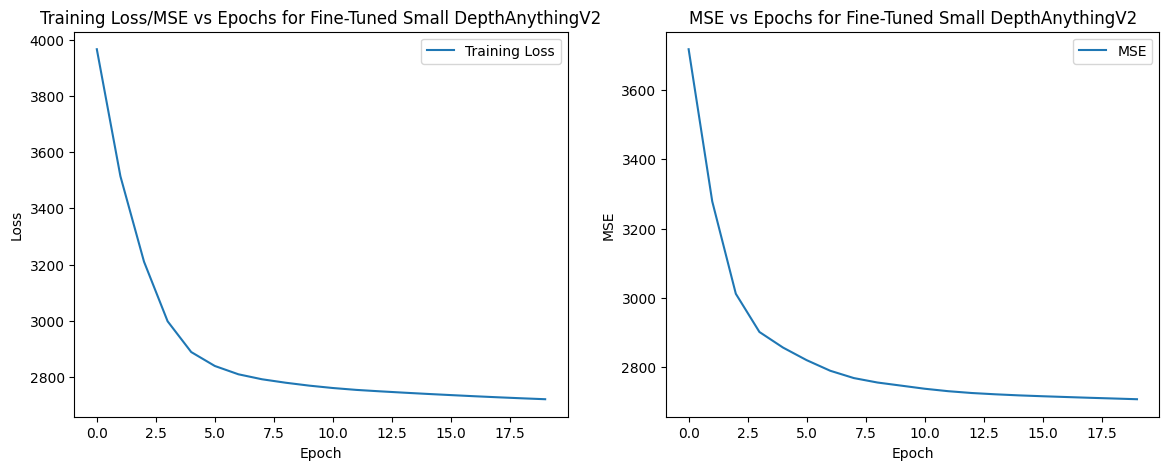

In [67]:

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epoch_losses, label='Training Loss')
plt.title("Training Loss/MSE vs Epochs for Fine-Tuned Small DepthAnythingV2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_mse, label='MSE')
plt.title("MSE vs Epochs for Fine-Tuned Small DepthAnythingV2")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

save_path = os.path.join(figures_dir, f"ft_model_loss_mse_curves.png")
plt.savefig(save_path, bbox_inches='tight', dpi=150)
print(f"Saved figure to {save_path}")

plt.show()

Saved figure to /content/figures/baseline_ft_gt_comparison_19.png


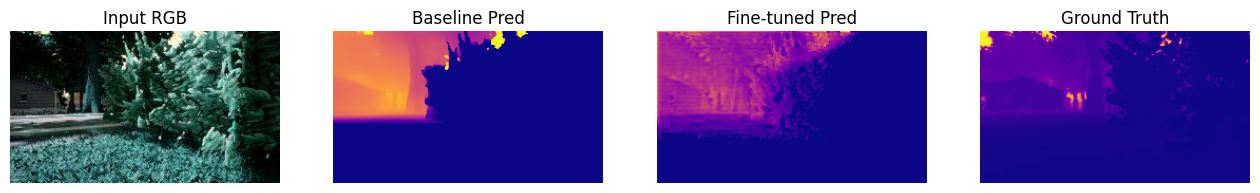

Saved figure to /content/figures/baseline_ft_gt_comparison_27.png


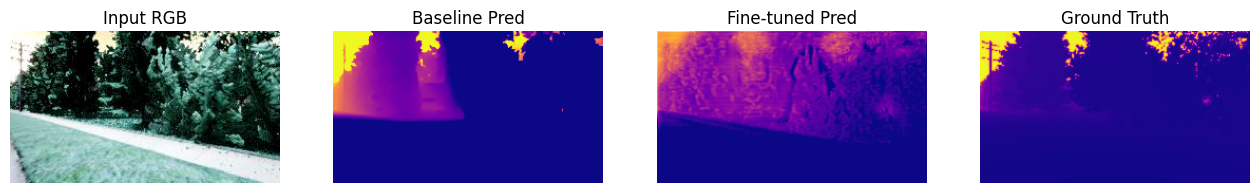

Saved figure to /content/figures/baseline_ft_gt_comparison_36.png


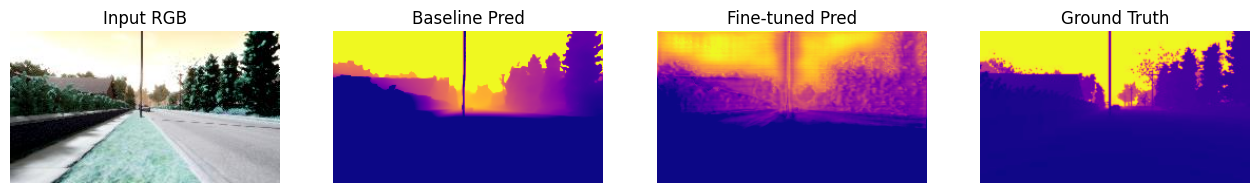

In [68]:

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from PIL import Image
import numpy as np
import random

# Fine-Tuned model
ft_model = DepthAnythingV2(
    encoder="vits",
    features=64,
    out_channels=[48, 96, 192, 384]
)

# Load the fine-tuned weights
ft_model.load_state_dict(torch.load(ft_save_path, map_location=device))
ft_model.to(device)
ft_model.eval()

 # Baseline pretrained model
model = DepthAnythingV2(
    encoder="vits",
    features=64,
    out_channels=[48, 96, 192, 384]
)
# Load the baseline weights
state = torch.load(checkpoint, map_location="cpu", weights_only=True)
model.load_state_dict(state)
model.to(device)
model.eval()

num_examples = 3  # number of random examples to visualize
random_indices = random.sample(range(len(pairs)), min(num_examples, len(pairs)))

for i in random_indices:
    rgb_path, gt_path = os.path.join(folder, pairs[i][0]), os.path.join(folder, pairs[i][1])

    # Load input and GT
    arr_orig, x = load_rgb_image(rgb_path)  # original RGB and [1,3,H,W]
    gt = load_gt_image(gt_path)             # ground truth [H,W]
    H_orig, W_orig = arr_orig.shape[:2]

    # Resize GT to original input size
    gt_resized = np.array(Image.fromarray(gt).resize((W_orig, H_orig), Image.BILINEAR))

    x_tensor = torch.tensor(x).float().to(device)

    # --------------------------
    # Baseline prediction
    # --------------------------
    with torch.no_grad():
        baseline_pred = model(x_tensor)
        if baseline_pred.ndim == 3:
            baseline_pred = baseline_pred.unsqueeze(1)
        baseline_pred = F.interpolate(baseline_pred, size=(H_orig, W_orig), mode="bilinear", align_corners=True)
        baseline_pred_np = postprocess_pred(baseline_pred.cpu().numpy())

    # --------------------------
    # Fine-tuned prediction
    # --------------------------
    with torch.no_grad():
        ft_pred = ft_model(x_tensor)
        if ft_pred.ndim == 3:
            ft_pred = ft_pred.unsqueeze(1)
        ft_pred = F.interpolate(ft_pred, size=(H_orig, W_orig), mode="bilinear", align_corners=True)
        ft_pred_np = postprocess_pred(ft_pred.cpu().numpy())

    # --------------------------
    # Plot comparison
    # --------------------------
    plt.figure(figsize=(16,4))

    plt.subplot(1,4,1)
    plt.imshow(arr_orig.astype(np.uint8))
    plt.title("Input RGB")
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(baseline_pred_np, cmap='plasma')
    plt.title("Baseline Pred")
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(ft_pred_np, cmap='plasma')
    plt.title("Fine-tuned Pred")
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.imshow(gt_resized, cmap='plasma')
    plt.title("Ground Truth")
    plt.axis('off')

    save_path = os.path.join(figures_dir, f"baseline_ft_gt_comparison_{i}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    print(f"Saved figure to {save_path}")

    plt.show()